In [1]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
from nnfs.datasets import sine_data
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nnfs.init()

In [3]:
# Dense layer
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons,weight_regularizer_l1=0, weight_regularizer_l2=0,bias_regularizer_l1=0, bias_regularizer_l2=0):
        
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
        
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

        
    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
    
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
    
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [4]:
# ReLU activation
class Activation_ReLU:
    # Forward pass
    
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)
        
    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


In [5]:
# Softmax activation
class Activation_Softmax:
    # Forward pass
    
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
        self.output = probabilities
        
    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output and
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,single_dvalues)

## Sigmoid activation 

In [6]:
# Sigmoid activation
class Activation_Sigmoid:
    
    # Forward pass
    def forward(self, inputs):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        
    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output


## Linear Activation 

In [7]:
class Activation_Linear:
    
    # Forward pass
    def forward(self, inputs):
        # Just remember values
        self.inputs = inputs
        self.output = inputs
        
    # Backward pass
    def backward(self, dvalues):
       # derivative is 1, 1 * dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy() 

## SGD optimizer

In [8]:

class Optimizer_SGD:
    
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    # Update parameters
    def update_params(self, layer):
        # If we use momentum
        if self.momentum:
            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            # Build bias updates
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
            
        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
            
        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates
        
    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


## Adagrad optimizer

In [9]:
class Optimizer_Adagrad:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        
        # Call once before any parameter update
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2
        
        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
            
    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


## RMSprop optimizer

In [10]:
class Optimizer_RMSprop:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


## Adam optimizer

In [11]:
class Optimizer_Adam:
    # Initialize optimizer - set settings
    
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
            
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
        
        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) +self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) +self.epsilon)
        
    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1



## Common loss class

In [12]:
# Common loss class
class Loss:
    # Regularization loss calculation
    
    def regularization_loss(self, layer):
        # 0 by default
        regularization_loss = 0
        
        # L1 regularization - weights
        # calculate only when factor greater than 0
        
        
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            
        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

        # L1 regularization - biases
        # calculate only when factor greater than 0
            
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            
            # L2 regularization - biases
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        
        return regularization_loss
    
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):
        
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        
        return data_loss

## Cross-entropy loss
 

In [13]:
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)
        
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples),y_true]
            
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true,axis=1)
            
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods


## Binary cross-entropy loss

In [14]:
class Loss_BinaryCrossentropy(Loss):
    
    # Forward pass
    def forward(self, y_pred, y_true):
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)
        # Return losses
        return sample_losses
    
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -(1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples

## Backward pass 

In [15]:
def backward(self, dvalues, y_true):
    # Number of samples
    samples = len(dvalues)
    # Number of labels in every sample
    # We'll use the first sample to count them
    labels = len(dvalues[0])
    # If labels are sparse, turn them into one-hot vector
    if len(y_true.shape) == 1:
        y_true = np.eye(labels)[y_true]
        
    # Calculate gradient
    self.dinputs = -y_true / dvalues
    # Normalize gradient
    self.dinputs = self.dinputs / samples


## Softmax classifier 

In [16]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():
    # Creates activation and loss function objects
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
    
    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    
    # Backward pass
    def backward(self, dvalues, y_true):
        
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
            
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        
        # Normalize gradient
        self.dinputs = self.dinputs / samples

## Dropout 

In [17]:
# Dropout
class Layer_Dropout:
    
    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate
    
    # Forward pass
    def forward(self, inputs):
        # Save input values
        self.inputs = inputs
        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask

    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask

## Mean Absolute Error loss

In [18]:
class Loss_MeanAbsoluteError(Loss): # L1 loss
    
    def forward(self, y_pred, y_true):
        # Calculate loss
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
        # Return losses
        return sample_losses
    
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])
        
        # Calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / outputs
        
        # Normalize gradient
        self.dinputs = self.dinputs / samples


## Mean Squared Error loss

In [19]:
class Loss_MeanSquaredError(Loss): # L2 loss
    # Forward pass
    def forward(self, y_pred, y_true):
        # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        # Return losses
        return sample_losses
    
    # Backward pas
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])
        
        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        
        # Normalize gradient
        self.dinputs = self.dinputs / samples


## Regression Model Training

In [20]:
# Create Dataset
X, y = sine_data()

# Create Dense layer with 1 input feature and 64 output values
dense1 = Layer_Dense(1, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 1 output value
dense2 = Layer_Dense(64, 64)

# Create Linear activation:
activation2 = Activation_ReLU()

# Create third Dense layer with 64 input features (as we take output
# of previous layer here) and 1 output value
dense3 = Layer_Dense(64, 1)

# Create Linear activation:
activation3 = Activation_Linear()

# Create loss function
loss_function = Loss_MeanSquaredError()

# Create optimizer
optimizer = Optimizer_Adam(learning_rate=0.005, decay=1e-3)

# Accuracy precision for accuracy calculation
# There are no really accuracy factor for regression problem,
# but we can simulate/approximate it. We'll calculate it by checking
# how many values have a difference to their ground truth equivalent
# less than given precision
# We'll calculate this precision as a fraction of standard deviation
# of al the ground truth values
accuracy_precision = np.std(y) / 250

loss_acum = []
accuracy_acum = []
count = []
y_hat = []

# Train in loop
for epoch in range(10001):
    
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function
    # of first layer as inputs
    dense2.forward(activation1.output)
    
    # Perform a forward pass through activation function
    # takes the output of second dense layer here
    activation2.forward(dense2.output)
    
    # Perform a forward pass through third Dense layer
    # takes outputs of activation function of second layer as inputs
    dense3.forward(activation2.output)
    
    # Perform a forward pass through activation function
    # takes the output of third dense layer here
    activation3.forward(dense3.output)
    
    # Calculate the data loss
    data_loss = loss_function.calculate(activation3.output, y)
    
    # Calculate regularization penalty
    regularization_loss = loss_function.regularization_loss(dense1) + loss_function.regularization_loss(dense2)+ loss_function.regularization_loss(dense3)

    # Calculate overall loss
    loss = data_loss + regularization_loss
    
    # Calculate accuracy from output of activation2 and targets
    # To calculate it we're taking absolute difference between
    # predictions and ground truth values and compare if differences
    # are lower than given precision value
    
    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) < accuracy_precision)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate}')
        
    loss_acum.append(loss)
    accuracy_acum.append(accuracy)
    y_hat = predictions
    count.append(epoch)
        
    
    # Backward pass
    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

    


epoch: 0, acc: 0.002, loss: 0.500 (data_loss: 0.500, reg_loss: 0.000), lr: 0.005
epoch: 100, acc: 0.007, loss: 0.084 (data_loss: 0.084, reg_loss: 0.000), lr: 0.004549590536851684
epoch: 200, acc: 0.033, loss: 0.034 (data_loss: 0.034, reg_loss: 0.000), lr: 0.004170141784820684
epoch: 300, acc: 0.020, loss: 0.003 (data_loss: 0.003, reg_loss: 0.000), lr: 0.003849114703618168
epoch: 400, acc: 0.618, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0035739814152966403
epoch: 500, acc: 0.605, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.00333555703802535
epoch: 600, acc: 0.732, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0031269543464665416
epoch: 700, acc: 0.763, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.002942907592701589
epoch: 800, acc: 0.778, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0027793218454697055
epoch: 900, acc: 0.789, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0026329647182727752
epoch: 1000, acc: 0.135, loss: 0.0

epoch: 8300, acc: 0.955, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005376922249704269
epoch: 8400, acc: 0.968, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005319714863283328
epoch: 8500, acc: 0.966, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005263711969681019
epoch: 8600, acc: 0.966, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005208875924575476
epoch: 8700, acc: 0.967, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005155170636148056
epoch: 8800, acc: 0.972, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005102561485865905
epoch: 8900, acc: 0.969, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005051015254066068
epoch: 9000, acc: 0.967, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005000500050005
epoch: 9100, acc: 0.968, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0004950985246063966
epoch: 9200, acc: 0.959, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0004902441415825081
epo

## Validate the model 

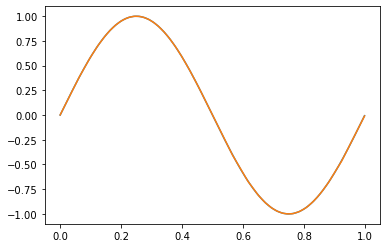

In [23]:
X_test, y_test = sine_data()

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()


<AxesSubplot:>

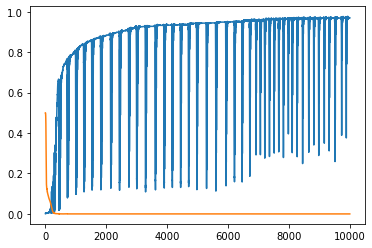

In [24]:
sns.lineplot(y=accuracy_acum , x=count)
sns.lineplot(y=loss_acum, x=count)
# plt.ylim(0, 5)